This iPython notebook documents the support vector machine (SVM) methdology used for gridding categorical seafloor lithology data as described in 

Dutkiewicz, A., Müller, R.D., O’Callaghan, S. and Jónasson, H., 2015, Census of seafloor sediments in the world's ocean, Geology, 43, 795–798.

the paper is open-access and can be downloaded from here:

http://geology.gsapubs.org/content/43/9/795.long

and the SVM method is described in detail in the supplementary material for the paper:

ftp://rock.geosociety.org/pub/reposit/2015/2015271.pdf

Start with loading all the packages needed.

In [1]:

%matplotlib inline  
import os
import numpy as np
import matplotlib.pyplot as pl
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

Next we define a method that calibrates and trains a classifier called
SVM (Support Vector Machine) Classifier. This classifier can later be used to do prediction.

To do this, it needs to learn the relationship between the input and the output.
This is done as a supervised learning task, meaning that it looks at past observations of input-output pairs and
learns a pattern from it. Then, later, it can use the learned pattern to predict what the outputs would be for 
a set of new, query inputs.

Thus, it needs two things to learn the pattern:
* The observed locations for the input.
* The corresponding observed locations for the output (so that they are paired up properly)

This method gives us the trained SVM classifier that is able to do prediction

Later on, to do prediction, the SVM classifier will need:
* The query locations for the input (which is where we want to know what the corresponding outputs are. So that it can output
* The predicted outputs at those query locations

The calibration here is done using a cross-validation approach.
This means we split the available data into multiple groups.

Some groups are withheld from the model, whereas the others remain available to the model.
Validation means that the model learn patterns from the remaining available data and tests its 
predictive power on the withheld data it was not allowed to see. It then records how well it does
as a performance score.

Cross-validation means that it switches which groups are withheld and which groups are not,
and averages all these performance scores together.


In [2]:
def svm_cross_val(observed_inputs, observed_outputs):

    # Define a grid of kernel parameters to search from
    C_range = 10.0 ** np.linspace(-2, 3, 8)
    gamma_range = 10 ** np.linspace(-2, 1, 6)
    param_grid = dict(gamma=gamma_range, C=C_range)

    # Set up cross-validation folds and train SVM
    cv = StratifiedKFold(y=observed_outputs, n_folds=5)
    grid = GridSearchCV(SVC(kernel='rbf', probability=True, class_weight={6: 10, 7: 10}), 
                        param_grid=param_grid, cv=cv, verbose=3, n_jobs=5)
    grid.fit(observed_inputs, observed_outputs)
    svc = grid.best_estimator_
    return svc

Load the data. Make sure you put the data file in the same folder as this ipython notebook!
If is the file name is incorrect here, change it appropriately.

In [3]:
file_name = '/seafloor_data.npz'
print('Loading data...')
data = np.load(os.getcwd() + file_name)
print('Data loaded.')

Loading data...
Data loaded.


Here we obtain the observed latitude, longitude locations. These are our observed inputs.
We also obtain the observed labels. These are our observed outputs.

In [4]:
lat = data['lat']
lon = data['lon']
labels = data['labels'].ravel().astype(int)

Next we pad the observed data on both sides of the map.

Instead of having the map going from -180 degrees longitude to 180 degrees longitude,
we will add another 10 degrees of longitude on both sides so that the map goes from -190 degrees longitude
to 190 degrees longitude.

This allows the SVM to actually make use of the observations that are on the edges of the map properly.
For example, an observation at 179 degrees longitude is actually very close to -179 degrees longitude, but because
those numbers (-179 and 179) are very far, the model will not know that. Instead, we copy both sides of the map and
paste it on the other sides of the map to extend the map, so that the observations at -179 degrees longitude will
also be registered as an observation at 181 degrees longitude, so that the model now knows that it is close to an 
observation at 179 degrees longitude, for example.

In [5]:
def pad_map(lon, lat, labels):
    
    east_strip_indices = (lon >  170) * (lon <  180)
    west_strip_indices = (lon < -170) * (lon > -180)

    lon_east_pad = lon[west_strip_indices] + 360
    lat_east_pad = lat[west_strip_indices]
    label_east_pad = labels[west_strip_indices[:, 0]]

    lon_west_pad = lon[east_strip_indices] - 360
    lat_west_pad = lat[east_strip_indices]
    label_west_pad = labels[east_strip_indices[:, 0]]

    lon_pad = np.append(lon_west_pad, np.append(lon, lon_east_pad))
    lat_pad = np.append(lat_west_pad, np.append(lat, lat_east_pad))
    labels_pad = np.append(label_west_pad, np.append(labels, label_east_pad))
    
    return lon_pad, lat_pad, labels_pad

lon, lat, labels = pad_map(lon, lat, labels)

Here we collected our observed data.

In [6]:
x = np.array([lon, lat]).T
y = labels

Here we generate the query locations - locations we want to predict what the output labels would be like.
Since we want to generate a map, we will basically query everywhere on the map, from -180 degrees longitude
to 180 degrees longitude, and from -90 degrees latitude to 90 degrees latitude. These query points will form a grid
that is 1 degree apart from each other in both directions.

In [7]:
min_lons = -180
max_lons = 180
min_lats = -90
max_lats = 90
query_lons = np.linspace(min_lons, max_lons, 361)
query_lats = np.linspace(min_lats, max_lats, 181)
xeva, yeva = np.meshgrid(query_lons, query_lats)
xs = np.c_[xeva.ravel(), yeva.ravel()]

Here we visualise the locations we actually have observed data for. These are the data we use to learn a pattern
for classification.

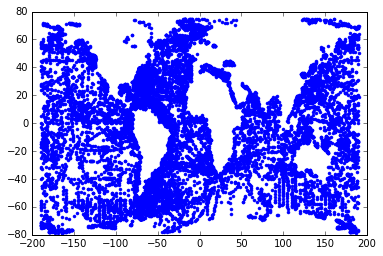

In [8]:
pl.plot(x[:,0], x[:,1], '.')
pl.show()

To Calibrate or Not To Calibrate:
Given the description above, decide if you want to calibrate the SVM classifier with cross-validation or not.
If not, then we will just use the pre-learnt configuration for the SVM classifier from the paper.
Note that calibration will take a long time! (Probably several hours)
Set the variable below to True or False appropriately.

In [9]:
to_calibrate = False

Here we use our SVM Classifier to learn patterns from the data, and then to predict the output labels for new
query input locations.

If you chose to have it calibrated, that means the SVM classifier has optimised a number of global parameters using a cross-validation approach. This will take a very long time.
Otherwise, we will just use the calibration from the paper.

In [10]:
if to_calibrate:
    print('Calibrating SVM Classifier parameters with cross-validation... This could take several hours.')
    classifier = svm_cross_val(x, y)
else:
    print('Training SVM Classifier without cross-validation... This will take a few minutes.')
    classifier = SVC(kernel='rbf', probability=True, C=1000, gamma=0.01, class_weight={6: 10, 7: 10})
    classifier.fit(x, y)
    
ys = classifier.predict(xs)

Training SVM Classifier without cross-validation... This will take about 5 minutes.


Visualise the prediction result from the SVM classifier with no training.

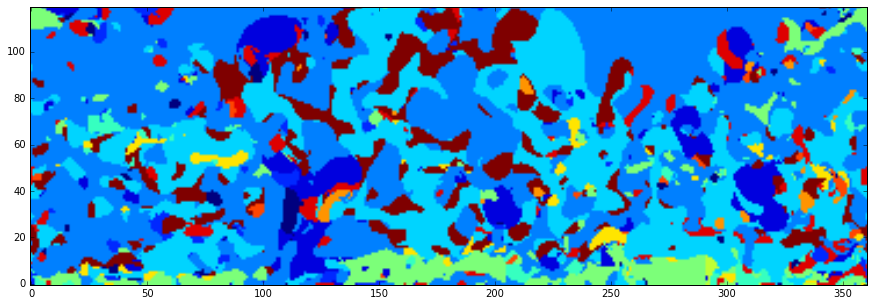

In [11]:
pl.figure(figsize=(15,15))
prediction_mesh = np.reshape(ys, xeva.shape)
pl.imshow(prediction_mesh[30:150,:], origin='lower')